In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

import tensorflow as tf

In [2]:
# Definimos y creamos la carpeta donde se guardarán los modelos.

carpeta_modelos = os.path.join(os.getcwd(), "Modelos")

cards_number_dir = os.path.join(carpeta_modelos, "cards_number")

os.makedirs(cards_number_dir, exist_ok=True)

print(f"Carpeta de modelos creada: {cards_number_dir}")

Carpeta de modelos creada: c:\Users\66439464\Desktop\PEC1AP\Modelos\cards_number


Preparación de datos

In [2]:
#Vamos a generar una nueva columna en nuestro dataset para asignar las categorías correspondientes a las cartas.

df=pd.read_csv(r"dataset/cards.csv")

# Mapeo de nombres de cartas a valores numéricos
rank_map = {
    'ace': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
    'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
    'jack': 11, 'queen': 12, 'king': 13, 'xxx': 0}

# Crear una nueva columna con el número de la carta

df['card_number'] = df['card type'].apply(lambda x: rank_map[x.split()[0]])

df.head()

,class index,filepaths,labels,card type,data set,card_number
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,1
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,1
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,1
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,1
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,1


Carga de datos

[ERROR] No existe el archivo: c:\Users\66439464\Desktop\PEC1AP\dataset\train/ace of clubs/output
Resumen de carga de imágenes:
Train: 7624
Test: 265
Valid: 265


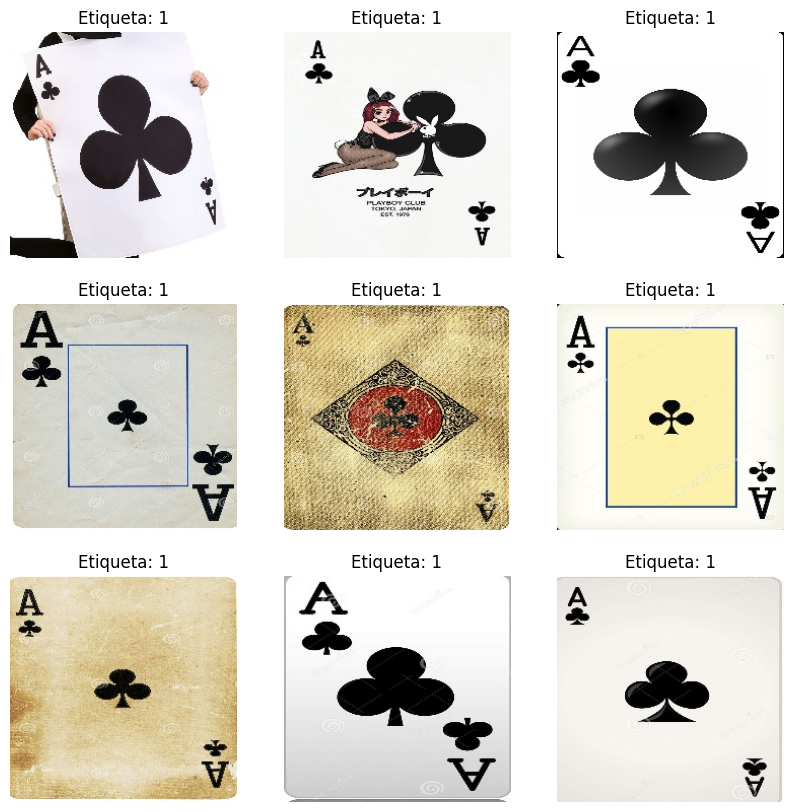


Se detectaron problemas con las siguientes rutas:
c:\Users\66439464\Desktop\PEC1AP\dataset\train/ace of clubs/output


In [3]:
#Carga de datos -> Primer hiperparámetro importante: Tamaño de carga de las imágenes.

# Listas para almacenar imágenes y etiquetas
X_train, Y_train = [], []
X_test, Y_test = [], []
X_val, Y_val = [], []

# Lista para registrar rutas de archivos problemáticos
errores = []

# Directorio base donde están las imágenes
dataset_dir = os.path.join(os.getcwd(), "dataset")

for index, row in df.iterrows():
    # Construir la ruta completa de la imagen uniendo el directorio base y la ruta relativa de 'filepaths'
    image_path = os.path.join(dataset_dir, row['filepaths'])
    label = row['card_number']
    
    if os.path.exists(image_path):
        image = cv.imread(image_path)
        if image is None:
            # Verificar que la imagen se leyó correctamente
            error_msg = f"[ERROR] No se pudo leer la imagen: {image_path}"
            print(error_msg)
            errores.append(image_path)
            continue

        try:
            # Redimensionar la imagen; ajustar el tamaño según lo requiera el entrenamiento (en este ejemplo 224x224)
            resized = cv.resize(image, (224, 224))
            # Distribuir la imagen y la etiqueta según el conjunto asignado en la columna 'data set'
            if row['data set'] == 'train':
                X_train.append(resized)
                Y_train.append(label)
            elif row['data set'] == 'test':
                X_test.append(resized)
                Y_test.append(label)
            else:
                X_val.append(resized)
                Y_val.append(label)
        except Exception as e:
            error_msg = f"[ERROR] No se pudo procesar {image_path}: {e}"
            print(error_msg)
            errores.append(image_path)
    else:
        error_msg = f"[ERROR] No existe el archivo: {image_path}"
        print(error_msg)
        errores.append(image_path)

# Comprobar la cantidad de imágenes cargadas
print("Resumen de carga de imágenes:")
print("Train:", len(X_train))
print("Test:", len(X_test))
print("Valid:", len(X_val))

# Visualizar algunas imágenes de entrenamiento (si hay)
if len(X_train) > 0:
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(X_train))):
        plt.subplot(3, 3, i+1)
        # Convertir BGR a RGB para una visualización correcta
        plt.imshow(cv.cvtColor(X_train[i], cv.COLOR_BGR2RGB))
        plt.title(f"Etiqueta: {Y_train[i]}")
        plt.axis('off')
    plt.show()

# Listar rutas problemáticas (si las hay)
if errores:
    print("\nSe detectaron problemas con las siguientes rutas:")
    for ruta in errores:
        print(ruta)
else:
    print("Todas las imágenes se han cargado correctamente.")

Pretratamiento y normalización

In [4]:
# Convert list with images to numpy array and reshape it
X_train = np.array(X_train).reshape(-1, 224, 224, 3)
X_test = np.array(X_test).reshape(-1, 224, 224, 3)
X_val = np.array(X_val).reshape(-1, 224, 224, 3)

# Copia de X sin normalizar
X_train_orig = X_train
X_test_orig = X_test
X_val_orig = X_val

# Scaling data in array
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Convert labels to onehotencoder format
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train = encoder.fit_transform(Y_train)
y_test = encoder.fit_transform(Y_test)
y_val = encoder.fit_transform(Y_val)

print(X_train.shape,X_test.shape,X_val.shape)
print(y_train[0])

(7624, 224, 224, 3) (265, 224, 224, 3) (265, 224, 224, 3)
[0 1 0 0 0 0 0 0 0 0 0 0 0 0]


Uso de ImageDataGenerator para incrementar el set de datos

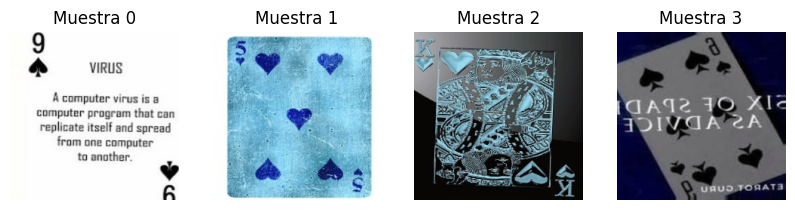

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical  # En caso de necesitar convertir etiquetas

# Configurar data augmentation para el entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=5,          # Rotar hasta 5 grados, para evitar que se oculte el número
    width_shift_range=0.05,    # Traslación horizontal del 5%
    height_shift_range=0.05,   # Traslación vertical del 5%
    shear_range=0.1,           # Cizallamiento reducido para menor distorsión
    zoom_range=0.05,           # Zoom del 5%
    horizontal_flip=True,      # Rotación horizontal
    fill_mode='nearest')     # Estrategia para rellenar píxeles faltantes

# Para validación y test, no aplicamos data augmentation, solo usamos un generador simple
val_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

batch_size = 32 #OJO CON ESTE BATCH SIZE!

# Crear generadores independientes

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

validation_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)


# Visualizar algunas imágenes aumentadas para confirmar las transformaciones del generador de entrenamiento.

sample_batch = next(train_generator)
sample_images = sample_batch[0]

plt.figure(figsize=(10, 8))
for i in range(0, 4):
    plt.subplot(1, 4, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Muestra {i}")
    plt.axis('off')
    
plt.show()

GENERACION DE MODELOS Y ENTRENAMIENTOS

In [ ]:
#Generacion del primer modelo FILTROS[16,32,64] CAPA_DENSA[128]

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Primer_modelo = Sequential([
    layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(14, activation='softmax')  # 14 clases con softmax para clasificación
])

# Compilamos el modelo con optimizador Adam y métricas relevantes
Primer_modelo.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy",  
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

# Mostramos el resumen del modelo
Primer_modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,448,046 (24.60 MB)

 Trainable params: 6,448,046 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', #Early Stopping monitorea val_loss pero puede indicarse val_accuracy.
                                                  patience=10, # Número de pases sin mejora después de las cuales se detendrá el entrenamiento.
                                                  min_delta=0.05, #Determina la minima mejora que debe tener para no parar el entrenamiento.
                                                  restore_best_weights=True)


#introducimos los chekpoints, estos guardan el mejor modelo después de actualizar todas las epochs
checkpoint = ModelCheckpoint('Modelos/cards_number/Primer_modelo.keras',
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only=True)

history_Primer_modelo = Primer_modelo.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[checkpoint,early_stopping]
)

Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.8645 - auc: 0.9902 - loss: 0.4299 - precision: 0.9279 - recall: 0.8188 - val_accuracy: 0.9019 - val_auc: 0.9911 - val_loss: 0.3356 - val_precision: 0.9336 - val_recall: 0.9019
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 96s 403ms/step - accuracy: 0.8723 - auc: 0.9919 - loss: 0.3973 - precision: 0.9313 - recall: 0.8248 - val_accuracy: 0.9208 - val_auc: 0.9910 - val_loss: 0.3381 - val_precision: 0.9331 - val_recall: 0.8943
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 100s 417ms/step - accuracy: 0.8745 - auc: 0.9936 - loss: 0.3765 - precision: 0.9213 - recall: 0.8351 - val_accuracy: 0.9170 - val_auc: 0.9972 - val_loss: 0.2638 - val_precision: 0.9370 - val_recall: 0.8981
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.8877 - auc: 0.9935 - loss: 0.3519 - precision: 0.9367 - recall: 0.8484 - val_accuracy: 0.9245 - val_auc: 0.9922 - val_loss: 0.2714 - val_precision: 0.9597 - val_recall: 0.8981
Epoch 5/50
239/23

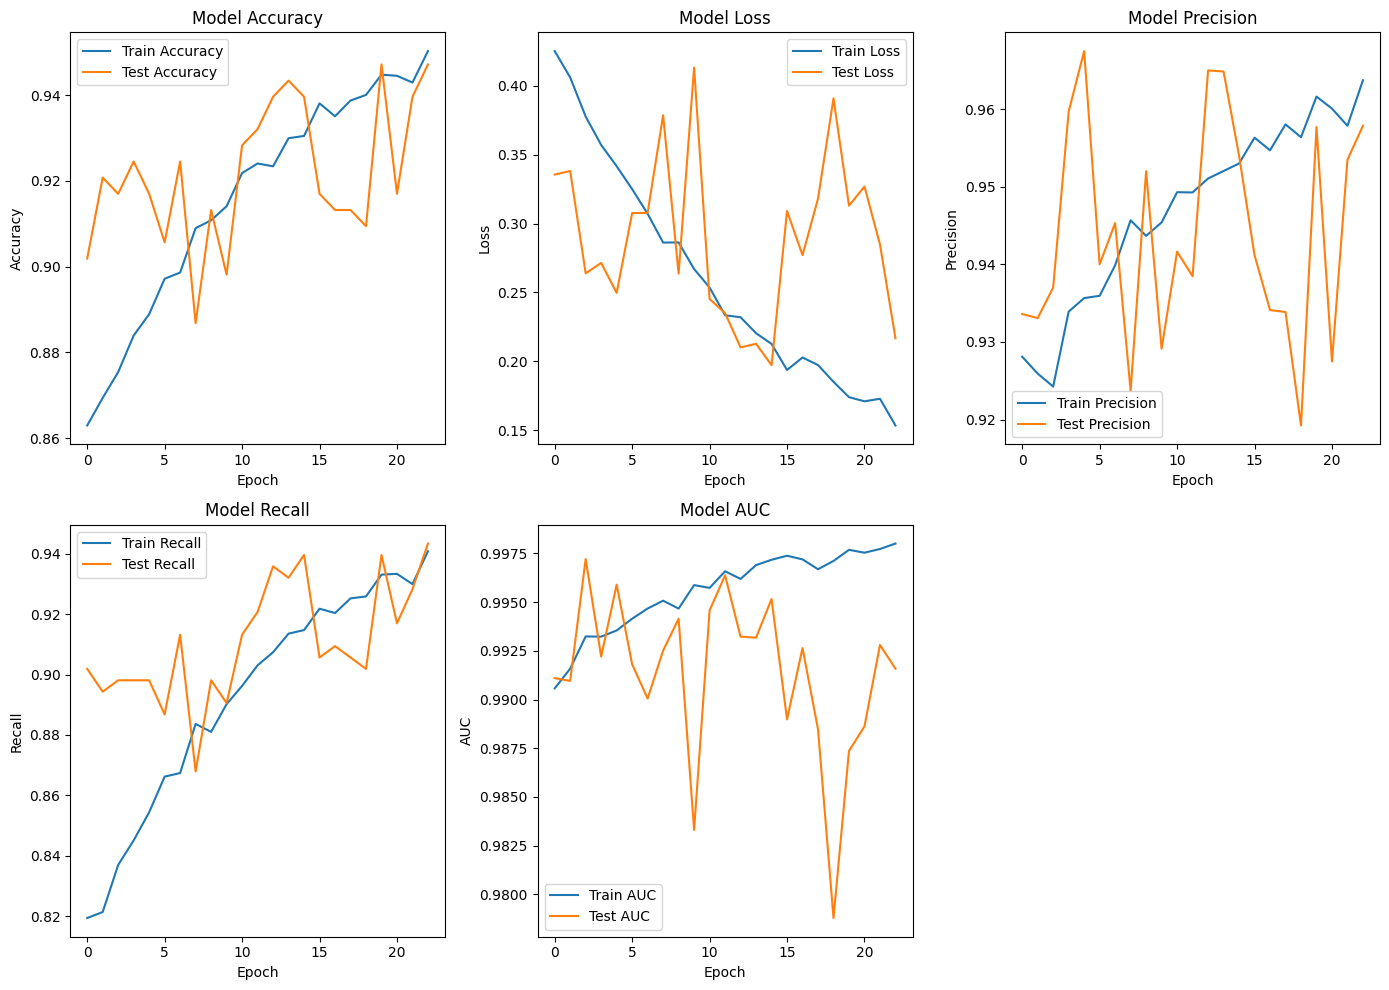

In [25]:
#Graficamos resultados:

import matplotlib.pyplot as plt

def graficar_resultados(history):
    """
    Función para graficar los resultados del entrenamiento del modelo.
    
    Parámetros:
    history: objeto History devuelto por el método model.fit()
    """
    plt.figure(figsize=(14, 10))

    # Accuracy
    plt.subplot(2, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(2, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Precision
    plt.subplot(2, 3, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Test Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 3, 4)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Test Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    # AUC
    plt.subplot(2, 3, 5)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Test AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()


graficar_resultados(history_Primer_modelo)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9557 - auc: 0.9920 - loss: 0.2266 - precision: 0.9582 - recall: 0.9530
Test Loss: 0.2119
Test Accuracy: 0.9547
Test Precision: 0.9618
Test Recall: 0.9509
Test AUC: 0.9937
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Aciertos: 253, Errores: 12


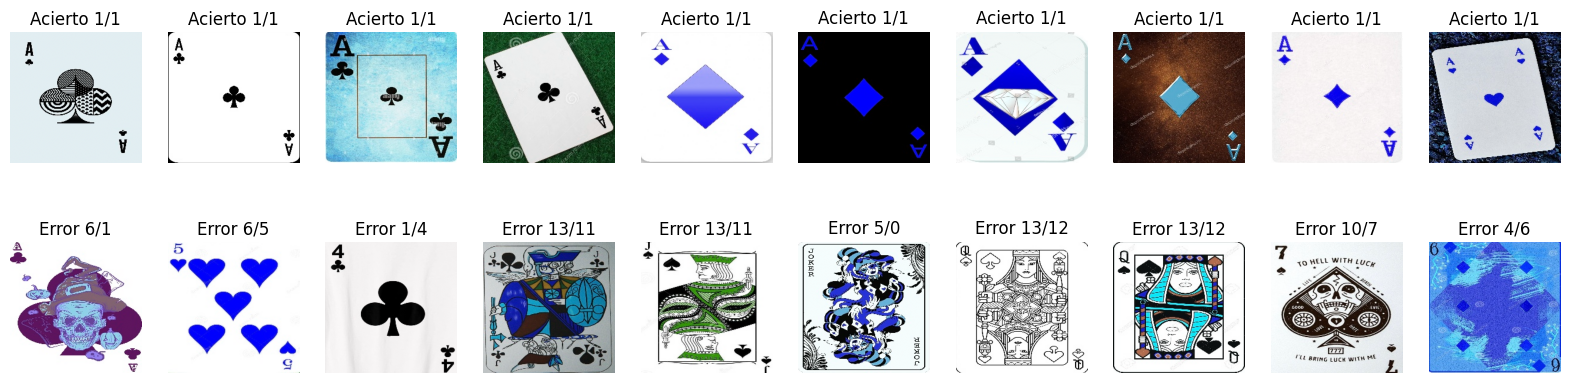

In [86]:
# Evaluar el modelo

#Nota, la variable validation_generator declarada al principio del cuaderno genera errores de sincronización con los datos,
#ya que genera un total de 264 etiquetas en lugar las 250 correctas.

validation_generator = val_datagen.flow(
    X_val, y_val, batch_size=batch_size, shuffle=False)

loss, accuracy, precision, recall, auc = Primer_modelo.evaluate(validation_generator, verbose=1)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test AUC: {auc:.4f}')

# Obtener predicciones sobre el conjunto de validación
predicciones = Primer_modelo.predict(validation_generator, verbose=1)
predicciones_clases = np.argmax(predicciones, axis=1)

# Obtener etiquetas verdaderas directamente desde y_val
etiquetas_verdaderas = np.argmax(y_val, axis=1)

# Identificar aciertos y errores
aciertos = np.where(predicciones_clases == etiquetas_verdaderas)[0]
errores = np.where(predicciones_clases != etiquetas_verdaderas)[0]

print(f"Aciertos: {len(aciertos)}, Errores: {len(errores)}")

# Función para obtener una imagen dada su posición en X_val
def obtener_imagen(global_index):
    return X_val[global_index], etiquetas_verdaderas[global_index]

# Seleccionar los primeros 10 aciertos y 10 errores
aciertos_mostrar = aciertos[:10]
errores_mostrar = errores[:10]

# Crear una figura con 2 filas y 10 columnas
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

# Mostrar aciertos
for i, idx in enumerate(aciertos_mostrar):
    img, etiqueta = obtener_imagen(idx)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Acierto {predicciones_clases[idx]}/{etiqueta}")
    axes[0, i].axis("off")

# Mostrar errores
for i, idx in enumerate(errores_mostrar):
    img, etiqueta = obtener_imagen(idx)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Error {predicciones_clases[idx]}/{etiqueta}")
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Aciertos", fontsize=14)
axes[1, 0].set_ylabel("Errores", fontsize=14)
plt.show()

In [9]:
#Vamos a aplicar drop out y realizar otro entrenamiento y vemos el resultado. Mismos filtros con dropout (0.2)
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Segundo_modelo = Sequential([
    Conv2D(16, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3)),
   
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(32, kernel_size=(3,3), padding='same'),
    
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, kernel_size=(3,3), padding='same'),
    
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    
    Dense(14, activation='softmax')  
])

Segundo_modelo.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy",  
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

Segundo_modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,448,046 (24.60 MB)

 Trainable params: 6,448,046 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  min_delta=0.01, 
                                                  restore_best_weights=True)



checkpoint = ModelCheckpoint('Modelos/cards_number/Segundo_moledo.keras',
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only=True)

history_Segundo_moledo = Segundo_modelo.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[checkpoint,early_stopping]
)

Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 440ms/step - accuracy: 0.8438 - auc: 0.9889 - loss: 0.4799 - precision: 0.9177 - recall: 0.7895 - val_accuracy: 0.8906 - val_auc: 0.9904 - val_loss: 0.3539 - val_precision: 0.9240 - val_recall: 0.8717
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 113s 472ms/step - accuracy: 0.8553 - auc: 0.9903 - loss: 0.4475 - precision: 0.9278 - recall: 0.8051 - val_accuracy: 0.8868 - val_auc: 0.9846 - val_loss: 0.4118 - val_precision: 0.9127 - val_recall: 0.8679
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 100s 419ms/step - accuracy: 0.8524 - auc: 0.9901 - loss: 0.4617 - precision: 0.9206 - recall: 0.8013 - val_accuracy: 0.8755 - val_auc: 0.9853 - val_loss: 0.4942 - val_precision: 0.9012 - val_recall: 0.8604
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 100s 418ms/step - accuracy: 0.8648 - auc: 0.9912 - loss: 0.4142 - precision: 0.9291 - recall: 0.8244 - val_accuracy: 0.8755 - val_auc: 0.9843 - val_loss: 0.4506 - val_precision: 0.9153 - val_recall: 0.8566
Epoch 5/50
239/2

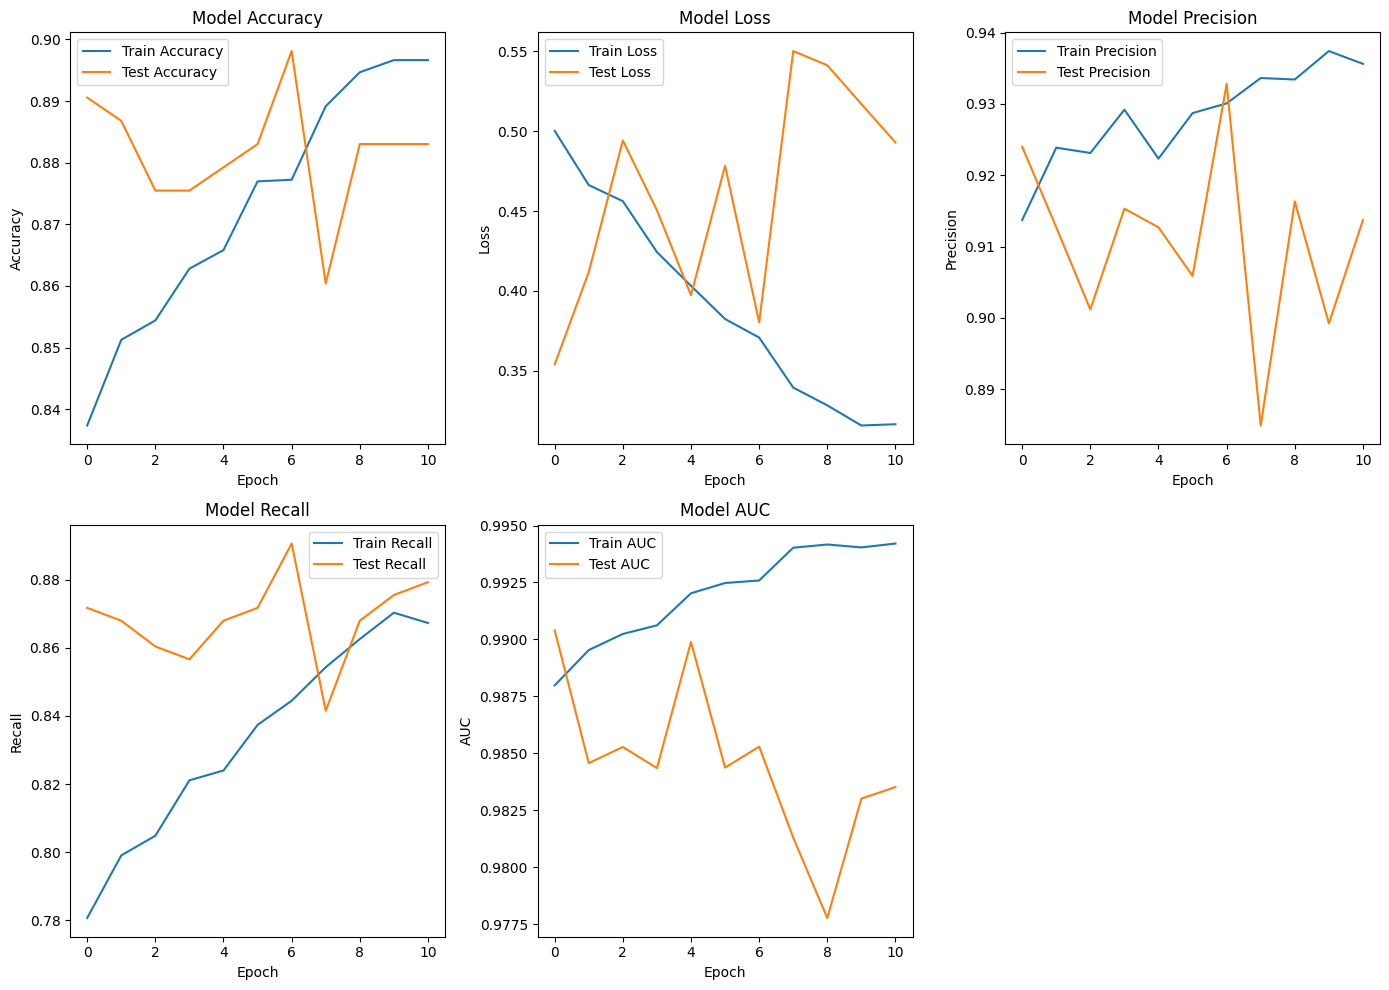

In [ ]:
#Vamos a graficar resultados:
graficar_resultados(history_Segundo_moledo)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9159 - auc: 0.9970 - loss: 0.2666 - precision: 0.9634 - recall: 0.8995
Test Loss: 0.2245
Test Accuracy: 0.9358
Test Precision: 0.9717
Test Recall: 0.9057
Test AUC: 0.9979
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Aciertos: 248, Errores: 17


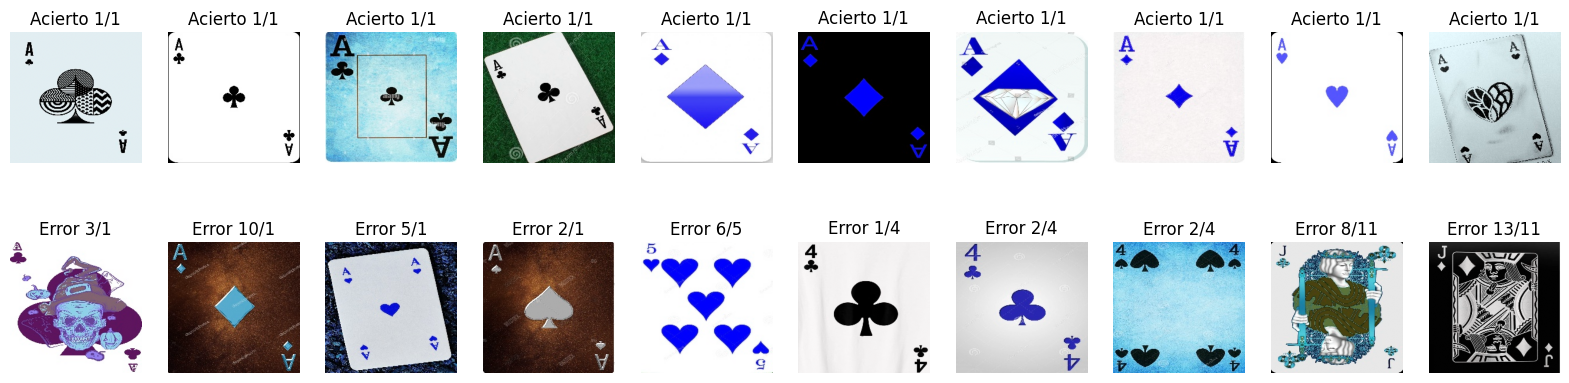

In [19]:
# Evaluar el modelo

#Nota, la variable validation_generator declarada al principio del cuaderno genera errores de sincronización con los datos,
#ya que genera un total de 264 etiquetas en lugar las 250 correctas.

validation_generator = val_datagen.flow(
    X_val, y_val, batch_size=batch_size, shuffle=False)

loss, accuracy, precision, recall, auc = Segundo_modelo.evaluate(validation_generator, verbose=1)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test AUC: {auc:.4f}')

# Obtener predicciones sobre el conjunto de validación
predicciones = Segundo_modelo.predict(validation_generator, verbose=1)
predicciones_clases = np.argmax(predicciones, axis=1)

# Obtener etiquetas verdaderas directamente desde y_val
etiquetas_verdaderas = np.argmax(y_val, axis=1)

# Identificar aciertos y errores
aciertos = np.where(predicciones_clases == etiquetas_verdaderas)[0]
errores = np.where(predicciones_clases != etiquetas_verdaderas)[0]

print(f"Aciertos: {len(aciertos)}, Errores: {len(errores)}")

# Función para obtener una imagen dada su posición en X_val
def obtener_imagen(global_index):
    return X_val[global_index], etiquetas_verdaderas[global_index]

# Seleccionar los primeros 10 aciertos y 10 errores
aciertos_mostrar = aciertos[:10]
errores_mostrar = errores[:10]

# Crear una figura con 2 filas y 10 columnas
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

# Mostrar aciertos
for i, idx in enumerate(aciertos_mostrar):
    img, etiqueta = obtener_imagen(idx)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Acierto {predicciones_clases[idx]}/{etiqueta}")
    axes[0, i].axis("off")

# Mostrar errores
for i, idx in enumerate(errores_mostrar):
    img, etiqueta = obtener_imagen(idx)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Error {predicciones_clases[idx]}/{etiqueta}")
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Aciertos", fontsize=14)
axes[1, 0].set_ylabel("Errores", fontsize=14)
plt.show()

Menor rendimiento que el primer modelo.....

In [50]:
#Aplicamos BatchNormalization para intentar mejorar resultados.

from tensorflow.keras.layers import BatchNormalization

Tercer_modelo = Sequential([
    Conv2D(16, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),  # Normalización después de la convolución
    layers.Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(32, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    layers.Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128),
    BatchNormalization(),
    layers.Activation('relu'),
    Dense(14, activation='softmax')  # 14 clases con softmax para clasificación
])

In [51]:
# Compilamos el modelo con optimizador Adam y métricas relevantes
Tercer_modelo.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy",  
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

Tercer_modelo.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,449,006 (24.60 MB)

 Trainable params: 6,448,526 (24.60 MB)

 Non-trainable params: 480 (1.88 KB)

In [58]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', #Vamos a monitorizar ahora val_accuracy.
                                                  patience=10, # Número de pases sin mejora después de las cuales se detendrá el entrenamiento.
                                                  min_delta=0.005, #Determina la minima mejora que debe tener para no parar el entrenamiento.
                                                  restore_best_weights=True)


checkpoint = ModelCheckpoint('Modelos/cards_number/Tercer_moledo.keras',
                             monitor='val_accuracy', 
                             verbose=0, 
                             save_best_only=True)

history_Tercer_moledo = Tercer_modelo.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[checkpoint,early_stopping])


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 194s 813ms/step - accuracy: 0.9023 - auc: 0.9950 - loss: 0.3127 - precision: 0.9513 - recall: 0.8720 - val_accuracy: 0.8830 - val_auc: 0.9851 - val_loss: 0.4175 - val_precision: 0.9271 - val_recall: 0.8642
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 202s 845ms/step - accuracy: 0.9029 - auc: 0.9958 - loss: 0.2957 - precision: 0.9448 - recall: 0.8702 - val_accuracy: 0.8868 - val_auc: 0.9895 - val_loss: 0.3975 - val_precision: 0.9306 - val_recall: 0.8604
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 199s 834ms/step - accuracy: 0.9094 - auc: 0.9959 - loss: 0.2836 - precision: 0.9545 - recall: 0.8776 - val_accuracy: 0.8717 - val_auc: 0.9871 - val_loss: 0.4535 - val_precision: 0.9221 - val_recall: 0.8491
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 203s 847ms/step - accuracy: 0.9221 - auc: 0.9970 - loss: 0.2417 - precision: 0.9556 - recall: 0.8914 - val_accuracy: 0.8642 - val_auc: 0.9886 - val_loss: 0.4489 - val_precision: 0.9259 - val_recall: 0.8491
Epoch 5/50
239/2

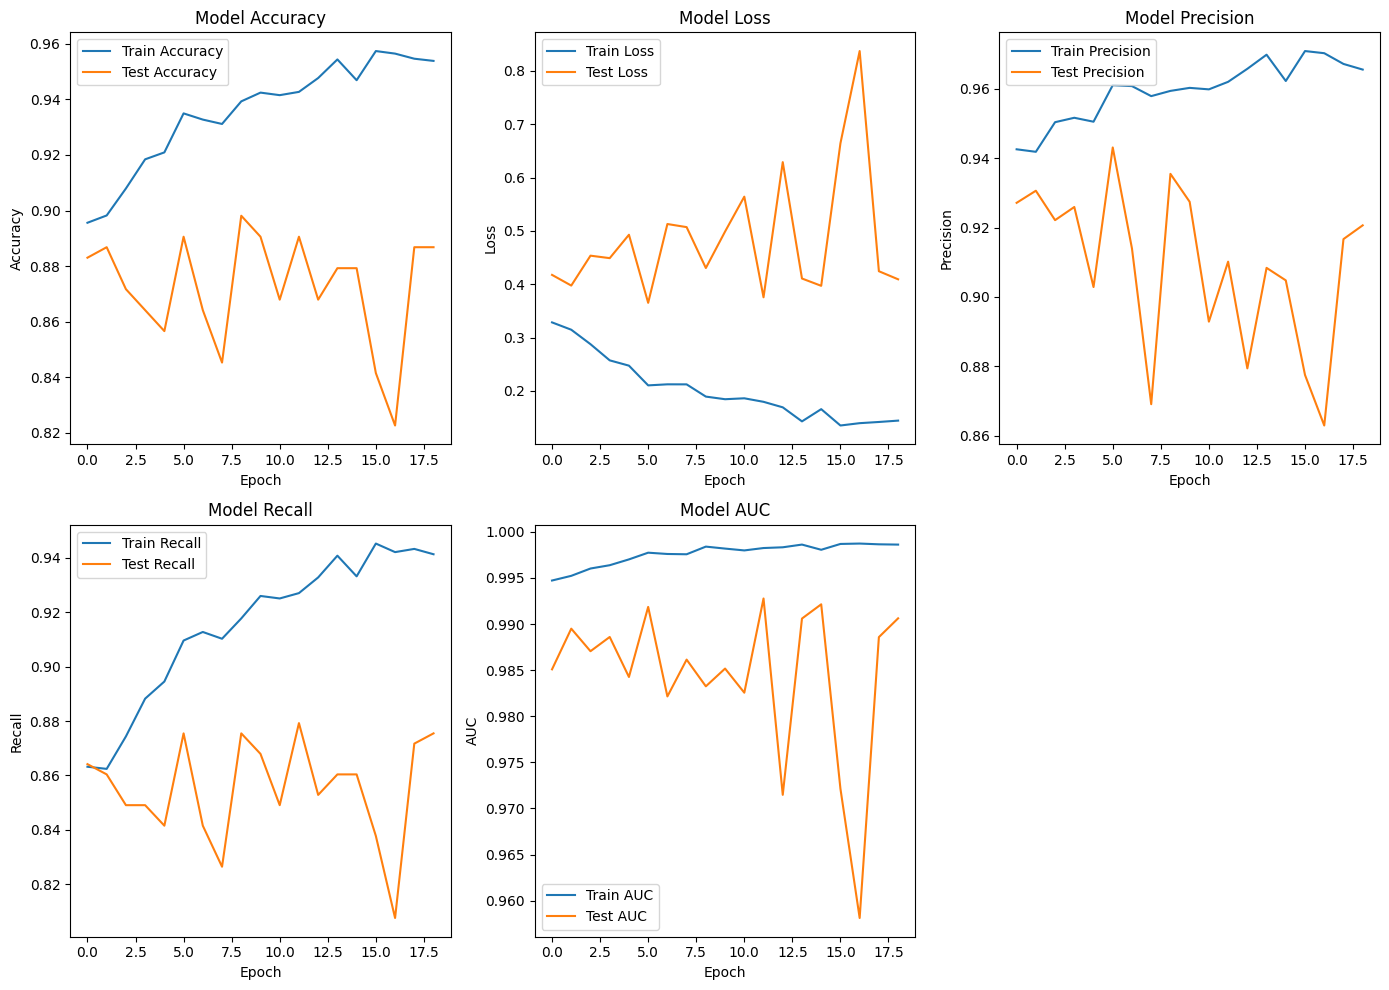

In [59]:
#Vamos a graficar resultados:
graficar_resultados(history_Tercer_moledo)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9311 - auc: 0.9920 - loss: 0.2513 - precision: 0.9347 - recall: 0.9211
Test Loss: 0.2427
Test Accuracy: 0.9283
Test Precision: 0.9346
Test Recall: 0.9170
Test AUC: 0.9927
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
Aciertos: 246, Errores: 19


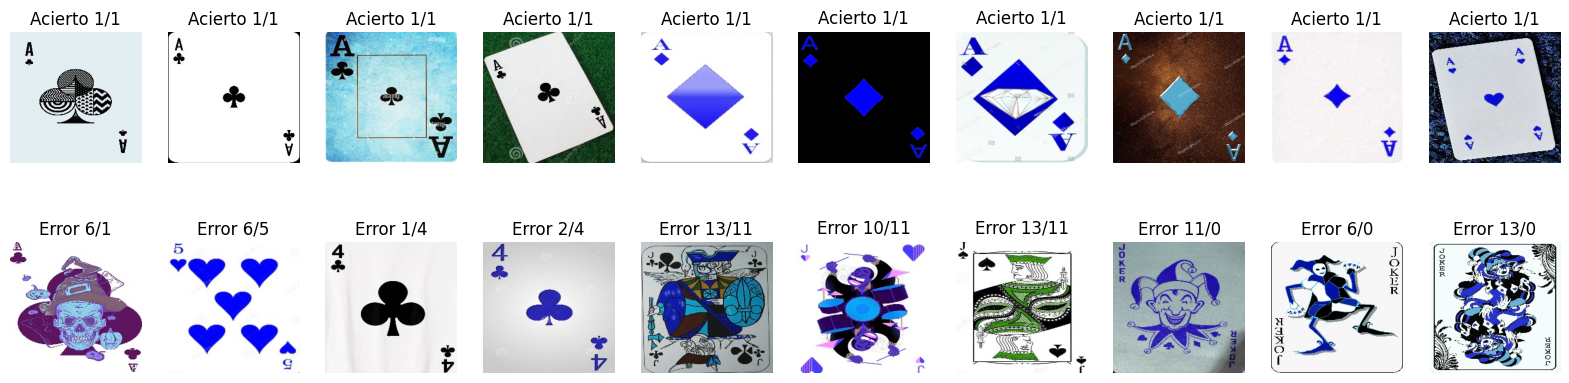

In [87]:
loss, accuracy, precision, recall, auc = Tercer_modelo.evaluate(validation_generator, verbose=1)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test AUC: {auc:.4f}')

# Obtener predicciones sobre el conjunto de validación
predicciones = Tercer_modelo.predict(validation_generator, verbose=1)
predicciones_clases = np.argmax(predicciones, axis=1)

# Obtener etiquetas verdaderas directamente desde y_val
etiquetas_verdaderas = np.argmax(y_val, axis=1)

# Identificar aciertos y errores
aciertos = np.where(predicciones_clases == etiquetas_verdaderas)[0]
errores = np.where(predicciones_clases != etiquetas_verdaderas)[0]

print(f"Aciertos: {len(aciertos)}, Errores: {len(errores)}")

# Seleccionar los primeros 10 aciertos y 10 errores
aciertos_mostrar = aciertos[:10]
errores_mostrar = errores[:10]

# Crear una figura con 2 filas y 10 columnas
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

# Mostrar aciertos
for i, idx in enumerate(aciertos_mostrar):
    img, etiqueta = obtener_imagen(idx)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Acierto {predicciones_clases[idx]}/{etiqueta}")
    axes[0, i].axis("off")

# Mostrar errores
for i, idx in enumerate(errores_mostrar):
    img, etiqueta = obtener_imagen(idx)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Error {predicciones_clases[idx]}/{etiqueta}")
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Aciertos", fontsize=14)
axes[1, 0].set_ylabel("Errores", fontsize=14)
plt.show()

No se observa una mejora significa con BatchNormalization, por lo que nos quedaremos de momento con el primer modelo.